# Prediction of Coronary Artery Heart Disease Using Key Clinical Indicators - A K-Nearest Neighbors Approach


## Introduction
Heart diseases are serious cardiovascular conditions that can be fatal. These diseases, notably, coronary artery disease (CAD), represent a primary global health challenge, often leading to severe morbidity and mortality. CAD arises from the progressive accumulation of atherosclerotic plaques within coronary vessels, ultimately impairing cardiac function. The purpose of this project is to predict the presence of heart disease in patients based on different medical attributes using a K-Nearest Neighbors (KNN) prediction method. As the capability to foresee the onset of such conditions using predictive analytics can significantly improve clinical outcomes by enabling preemptive medical intervention. 

This method will allow us to analyze data sets collected from medical research, so we can categorize data points into groups, compared to other similar data points. The data set that we will be using is based on medical research across several institutions including Cleveland Clinic, Hungarian Institute of Cardiology, University Hospital in Zurich, and VA Long Beach. This data set contains fourteen attributes commonly identified in heart disease such as age, sex, cholesterol, and more. These are important factors in being able to predict heart diseases in patients of all ages. This project is made specifically to answer the question: "Can heart disease be diagnosed accurately by select medical attributes?" By resolving this query, the study seeks to contribute  to the predictive diagnostics in cardiology, ultimately aiding in the reduction of CAD prevalence.

# Methods and Results

To begin this exploration, we must first import the libraries we will be using throughout the project, these allow for easy data manipulation as well as graphing tools:

In [21]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(tidyclust)
library(repr)
library(GGally)

With the use of `read_excel`, from the `readxl` library, the data from `heart_disease.xlsx` which comes from the original database. 
The data is then visualised through the use of `head`, which allows us to see the different types of data within the file.

In [22]:
data <- read_excel('data/heart_disease.xlsx')
head(data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


Table 1 Read heart disease excel data 

Clearly, both `ca` and `thal` should not be characters, and therefore need to be converted to numeric values. Furthermore, we must also
prepare this data so it can be used for our K-NN algorithm, for this, we first need to create a diagnosis column. This factor column will indicate if there is an illness present, which is the output this study aims to predict. The values of `num` represent the different diseases that can be found within the study, with 0 representing no illness, therefore these are converted so when `num` is not 0, diagnosis is given as 1, and 0 otherwise. Finally, `na.omit()` is used to remove any null rows.

In [23]:
heart_data <- data |> 
    mutate(
        ca = as.numeric(ca), 
        thal = as.numeric(thal), 
        diagnosis = if_else(num != 0, 1, 0), # Creates a new column 'diagnosis'
        diagnosis = as.factor(diagnosis) # Convert 'diagnosis' to factor
    ) |> 
    na.omit()

head(heart_data)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0,0


Table 1.1 Changed variable types to the types necessary for the planned analysis, as well as creating `diagnosis`

Finally, we will also select only relevant columns for our research, as certain columns such as `fbs` (Fasting Blood Sugar) and `restecg` (Resting Electrocardiographic Results) are boolean values that are not useful for our classification method. Creating then the `heart_data_clean` dataframe, which will be used for our algorithm.

In [24]:
heart_data_clean <- heart_data |>
    select(age, sex, cp, trestbps, chol, thalach, exang, oldpeak, slope, ca, thal, num, diagnosis)

head(heart_data_clean)

age,sex,cp,trestbps,chol,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,150,0,2.3,3,0,6,0,0
67,1,4,160,286,108,1,1.5,2,3,3,2,1
67,1,4,120,229,129,1,2.6,2,2,7,1,1
37,1,3,130,250,187,0,3.5,3,0,3,0,0
41,0,2,130,204,172,0,1.4,1,0,3,0,0
56,1,2,120,236,178,0,0.8,1,0,3,0,0


Table 1.2 Selected all relevant columns to clean data

### Analysis of predictors

In predictive modeling for coronary artery heart disease (CAD), the selection of input variables critically influences the efficacy and accuracy of the model. Our K-Nearest Neighbors (KNN) prediction model prioritizes clinical predictors substantiated by empirical evidence for their strong association with CAD. Among numerous potential predictors, five have been identified as particularly significant: age, sex, exercise-induced angina(exang), ST depression(oldpeak), and the number of major vessels with observable calcium during fluoroscopy(ca).

Age is a fundamental predictor of CAD, with the incidence of the disease escalating with increasing age (Ayatollahi et al., 2019, p. 2). This finding is mirrored by Detrano et al. (1989, p. 305), who incorporated age as a variable in their probability models for the diagnosis of CAD. The progressive nature of cardiovascular risk factors over time solidifies age as a paramount indicator for our KNN model.

Sex has been consistently identified as a differentiator in CAD prevalence, with distinct patterns observed between genders (Ayatollahi et al., 2019, p. 2). Similarly, Detrano et al. (1989, p. 305) included sex as a discrete variable, acknowledging its influence on the clinical presentation and prognosis of heart disease.

Exercise-induced angina (exang), symptomatic of myocardial ischemia, is indicative of significant coronary obstruction and has been directly incorporated into predictive assessments of CAD (Detrano et al., 1989, p. 305). The acuteness of this symptom in reflecting cardiovascular distress renders it a critical component for inclusion in our KNN model.

ST depression (oldpeak), quantified during stress tests, signals myocardial ischemia and has been employed by Detrano et al. (1989, p. 305) in their diagnostic algorithms. Its role in indicating the severity of ischemia, which is crucial in the evaluation of CAD, makes it an indispensable predictor for our analysis.

The number of major vessels (ca) identified with calcium during fluoroscopy, a direct measure of coronary artery blockages, is considered a potent predictor of CAD (Detrano et al., 1989, p. 305). This variable provides a quantifiable assessment of disease extent, significantly enhancing the prognostic value of our model.

These predictors are statistically significant and possess high clinical relevance, offering a focused and medically informed basis for our KNN predictive model, free from the clutter of less impactful variables. To further our model's accuracy though, it is key to expand our scope further. Our dataset provides five possible outcomes for the diagnosis, with each being a different disease, this inital model can aim to separate each  To achieve this a summarization of the means of each column can be generated and analysed.

In [25]:
summary_table <- heart_data |>
      group_by(diagnosis) |>
      summarise(across(where(is.numeric), list(mean = ~mean(.x, na.rm = TRUE))),
            Count = n())

summary_table

diagnosis,age_mean,sex_mean,cp_mean,trestbps_mean,chol_mean,fbs_mean,restecg_mean,thalach_mean,exang_mean,oldpeak_mean,slope_mean,ca_mean,thal_mean,num_mean,Count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,52.64375,0.5562500,2.793750,129.175,243.4938,0.1437500,0.843750,158.5813,0.143750,0.598750,1.412500,0.275000,3.787500,0.000000,160
1,56.75912,0.8175182,3.583942,134.635,251.8540,0.1459854,1.175182,139.1095,0.540146,1.589051,1.824818,1.145985,5.832117,2.051095,137


Table 1.2 Summary of the means of possible predictor variables depending on diagnosis

> These can then be graphed to allow for a comparison to be made between the two different diagnosis:

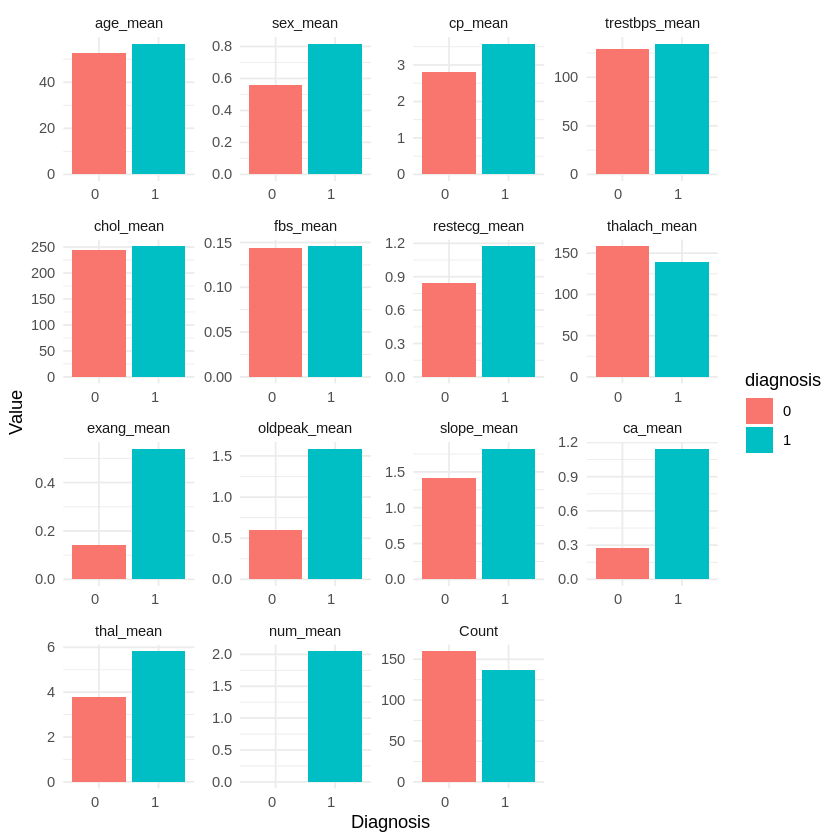

In [26]:
st_long <- reshape2::melt(summary_table, id.vars = 'diagnosis')

summary_plot <- ggplot(st_long, aes(x = diagnosis, y = value, fill = diagnosis)) +
  geom_bar(stat = "identity") + 
  facet_wrap(variable ~., scales = "free") + 
  labs(x = "Diagnosis", y = "Value") +
  theme_minimal() +
  theme(
    strip.text.x = element_text(angle = 0, hjust = 0.5),
    axis.text.x = element_text(angle = 0, hjust = 1)
  ) +
  scale_color_viridis_d()

summary_plot

Fig 1 Diagnosis vs Predictors (Mean) plot

With these we can see the clear difference in the means within certain columns. The graphs demonstrate how `trestbps_mean`,`chol_mean` and `fbs_mean` all have similar values, therefore, they will be removed from the predictors to allow for greater accuracy.

### Splitting the training and test dataset

With the data set cleaned and the predictors selected the data can now be split into both a training and testing set. This is done to create `heart_train` and `heart_test` which are going to be the two used dataframes.

In [27]:
set.seed(9998)

heart_split <- initial_split(heart_data, prop = 0.80, strata = diagnosis)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

heart_train |>
    slice(0:5)
heart_test |> 
    slice(0:5)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,0
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0,0
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0,0


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
62,0,4,140,268,0,2,160,0,3.6,3,2,3,3,1
63,1,4,130,254,0,2,147,0,1.4,2,1,7,2,1
44,1,2,120,263,0,0,173,0,0.0,1,0,7,0,0
60,1,4,130,206,0,2,132,1,2.4,2,2,7,4,1
64,1,3,140,335,0,0,158,0,0.0,1,0,3,1,1


Table 1.3 & 1.4 Split heart data into training and testing

### Application with K-NN Algorithm

To create the algorithm and find the best K-value there are five basic steps: a vfold, the creation of a tibble of possible K-values, the KNN model specification, the recipe for the fit, and finally a workflow to fit and test the different K-values. Each step is further explained by the comment on it.

In [28]:
# Set a seed for reproducibility
set.seed(9998)

# Prepare cross-validation with 5 folds, stratifying by the diagnosis variable to ensure
# each fold has a proportional distribution of diagnosis outcomes.
heart_vfold <- vfold_cv(heart_train, v = 5, strata = diagnosis)

# Create a tibble of neighbor values ranging from 20 to 30. These values will be tested to
# determine the best number of neighbors for the KNN model.
k_vals <- tibble(neighbors = c(20:30)) 

# Define the KNN model specification:
# - weight_func = "rectangular" indicates uniform weights.
# - set_engine("kknn") specifies the 'kknn' package for KNN computation.
# - set_mode("classification") sets the model mode to classification since 'diagnosis' is a categorical outcome.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Prepare the recipe for the model:
# - diagnosis ~ ... specifies the formula where 'diagnosis' is the outcome.
# - step_scale(all_predictors()) scales all predictor variables to have zero mean and unit variance.
# - step_center(all_predictors()) centers all predictor variables around zero.
heart_recipe <- recipe(diagnosis ~ age + sex + cp + restecg + thalach + exang + oldpeak + slope + ca + thal, data = heart_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

# Combine the recipe and model specification into a workflow, then apply the tuning grid to
# find the best 'k' value using the predefined cross-validation folds.
heart_fit <- workflow() |>
                     add_recipe(heart_recipe) |>
                     add_model(knn_spec) |>
                     tune_grid(resamples = heart_vfold, grid = k_vals)

Furthermore, a graph comparing K-values and accuracy allows for an easy visualisation of what the best value of K is, which as demonstrated in the graph generated below is 25.

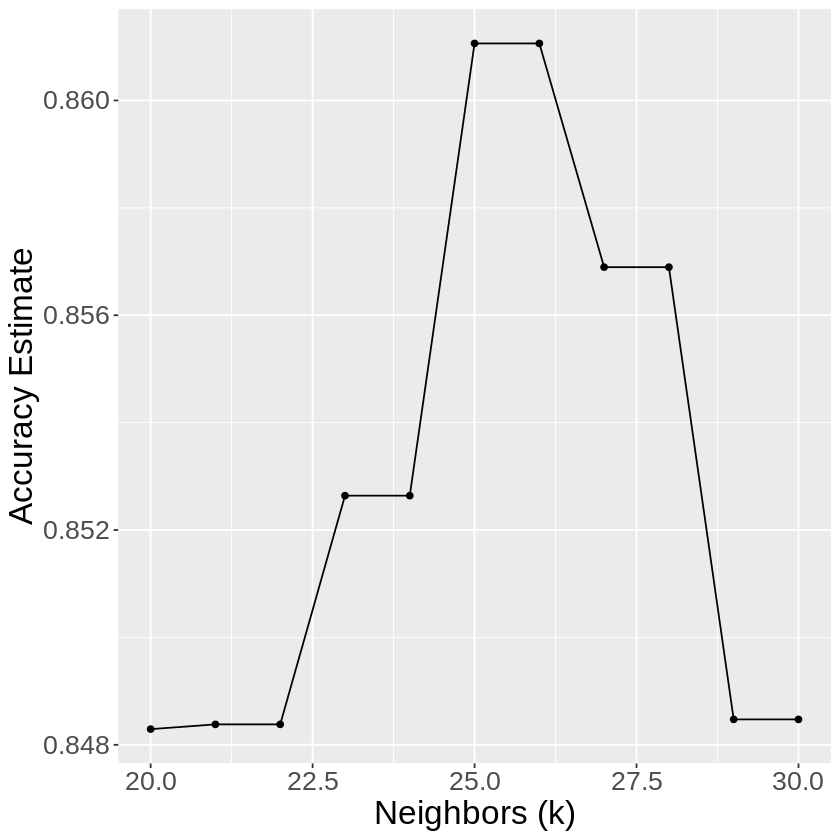

In [29]:
# Collect and store the results from the model tuning.
heart_results <- collect_metrics(heart_fit)

# Filter the results to only include accuracy metrics.
accuracies <- heart_results |>
              filter(.metric == "accuracy")

# Create a plot to visualize the relationship between 'k' values and accuracy.
# This helps in identifying the best 'k' value for the model.
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (k)", y = "Accuracy Estimate") +
       theme(text = element_text(size = 20)) 

# Display the plot
cross_val_plot
# K = 25 is determined to be the best K-value based on the plotted accuracies.

Fig 1.1 Estimated accuracy versus the neighbors (K). K = 16 gives the best accuracy.

Finally, a confusion matrix is generated to further analyse the accuracy of our model, and to showcase possible shortcomings.

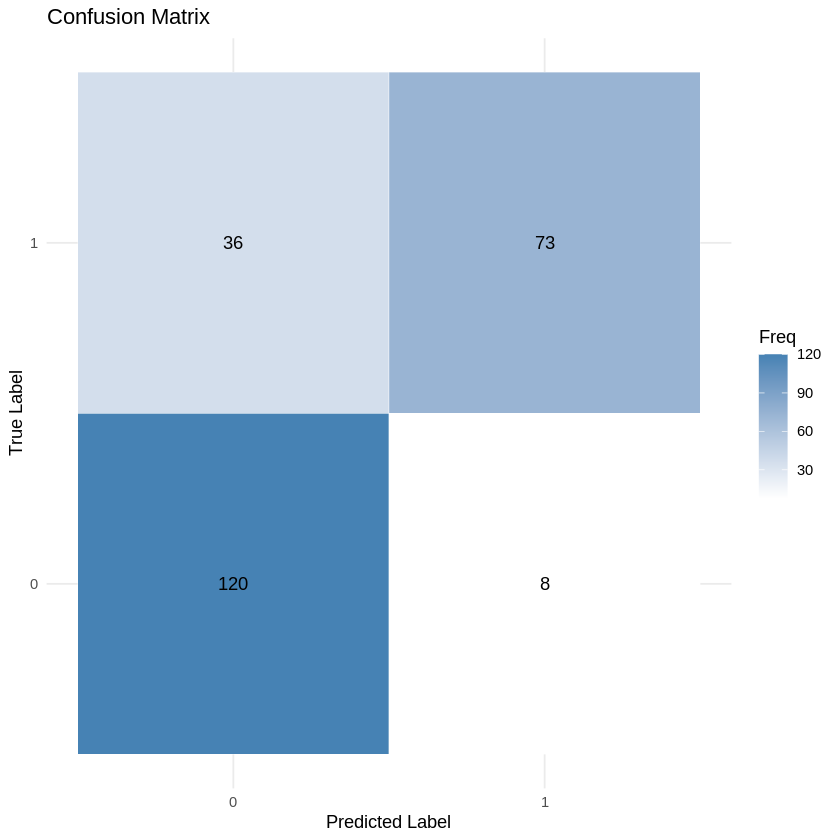

In [30]:
# Define the KNN model with k = 25
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
            set_engine("kknn") |>
            set_mode("classification")

# Create a new workflow with the final KNN specification
final_workflow <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(final_knn_spec)

# Fit the final model on the entire test dataset
final_fit <- fit(final_workflow, data = heart_test)

# Predict using the fitted model
predictions <- predict(final_fit, new_data = heart_train, type = "class") |>
    bind_cols(heart_train)

# Create confusion matrix
conf_mat <- table(Truth = predictions$diagnosis, Prediction = predictions$.pred_class)

# Convert the confusion matrix to a tidy format for ggplot
conf_mat_df <- as.data.frame(as.table(conf_mat))

# Plotting the matrix
ggplot(data = conf_mat_df, aes(x = Prediction, y = Truth, fill = Freq)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Freq), color = "black") +  
    scale_fill_gradient(low = "white", high = "steelblue") +  # Color gradient for visual emphasis
    labs(title = "Confusion Matrix", x = "Predicted Label", y = "True Label") +
    theme_minimal()

Fig 1.2 Confusion Matrix

## Summary of Findings:
We found that the optimal number of neighbors (K = 25) yielded a commendable average accuracy of approximately 86%. This level of accuracy was achieved through meticulous model tuning and validation, demonstrating the model's strong predictive capabilities. The confusion matrix demonstrates both a flaw and a strength of our model. When the model predicts a heart disease, it's accuracy is of 90.1%, yet it missed 36 of the 109 patients that had some kind of disease, which means that it only predicts true ilnesses with an accuracy of 76.9%.

### Expectations vs. Reality:
The high accuracy surpassed our initial expectations, especially given the complexities associated with CAD diagnosis involving multiple health indicators. We anticipated good performance due to the robust selection of predictors and were pleased to observe that the model performed even better than expected in general classification tasks. However, the model's less efficient in predicting actual cases, meaning more tests or variables can be used to further enhance this accuracy.

### Impact of Findings:
The high accuracy of the KNN model in diagnosing CAD has significant implications for clinical practice. Its ability to reliably identify patients without CAD could substantially reduce unnecessary medical testing and procedures, thus saving costs and focusing resources more effectively on patients who need further investigation and treatment. However, the model's limitations in identifying severe disease states suggest it should be used in conjunction with other diagnostic tools to ensure high-risk patients are accurately diagnosed.

### Future Research Directions:
The success and limitations observed in this study suggest several key areas for future research:

* Model Refinement for Severe Cases: Investigating approaches to enhance the model's sensitivity to severe CAD cases, potentially through the integration of additional diagnostic features or the use of more sophisticated machine learning algorithms.
* Algorithm Comparison and Ensemble Techniques: Comparing the KNN model's performance against other machine learning approaches and exploring ensemble methods could help improve accuracy across all CAD severity levels.
* Real-World Clinical Validation: Conducting studies to validate the model's effectiveness in real-world clinical settings across diverse patient populations will be crucial to assess its practical utility and adaptability.
* Cost-Effectiveness Analysis: Evaluating the cost-benefit ratio of implementing this KNN model in healthcare settings could provide insights into its economic impact, considering both the potential reductions in unnecessary testing and the implications of its current limitations.

### Conclusion:
Overall, the KNN model has proven to be a valuable tool for CAD diagnosis, with its high accuracy marking a significant step forward in predictive healthcare analytics. However, the disparity in performance across different severity levels of CAD underscores the need for ongoing improvements and cautious integration into clinical workflows. By continuing to refine this model and exploring its integration with other diagnostic methods, we can enhance its reliability and extend its applicability in improving patient outcomes in cardiology.

### References

[1] Ayatollahi, H., Gholamhosseini, L., & Salehi, M. (2019). Predicting coronary artery 
disease: A comparison between two data mining algorithms. BMC Public Health, 19(1), 448-448. https://doi.org/10.1186/s12889-019-6721-5

[2] Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American Journal of Cardiology, 64(5), 304-310. https://doi.org/10.1016/0002-9149(89)90524-9
